In [5]:
%matplotlib inline
%load_ext rmagic
print __doc__
import numpy as np
import pyart
import matplotlib.pyplot as plt
import netCDF4
import copy
import scipy.ndimage as nd
import numpy.ma as ma



The rmagic extension is already loaded. To reload it, use:
  %reload_ext rmagic
Automatically created module for IPython interactive environment


In [6]:
file='/home/sofia/Documents/Pyart/datos_polarimetria/cf/20090527/cfrad.20090527_145347.000_to_20090527_145735.000_INTA_Par_v1_SUR.nc'
radar=pyart.io.read_cfradial(file)

In [7]:
#datos para cada elevacion#
#ZDR
ZDR=radar.fields['ZDR']['data']
zdr=[]
for i in range(radar.nsweeps):
    zdr.append(ZDR[360*i+i:360*(i+1)+i])  

#RhoHV
RhoHV=radar.fields['RhoHV']['data']
rhohv=[]
for i in range(radar.nsweeps):
    rhohv.append(RhoHV[360*i+i:360*(i+1)+i])  

#V
V=radar.fields['V']['data']
v=[]
for i in range(radar.nsweeps):
    v.append(V[360*i+i:360*(i+1)+i])  
    
#dBZ
V=radar.fields['dBZ']['data']
dbz=[]
for i in range(radar.nsweeps):
    dbz.append(V[360*i+i:360*(i+1)+i])      


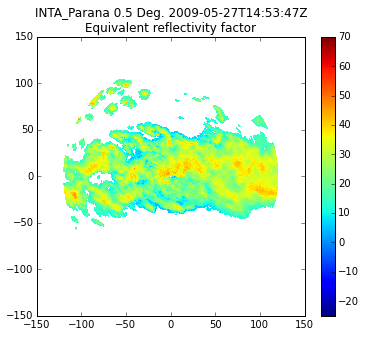

In [8]:
##Grafico ppi de los datos PPI de la primera elevacion
xlims=[-150,150]
ylims=[-150,150]

tilt=0  #elevacion??
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=(6, 5))
display.plot_ppi('dBZ', tilt,
                 colorbar_label='',
                 axislabels_flag=False,vmin=-25,vmax=70)
display.set_limits(xlims,ylims)
plt.show()

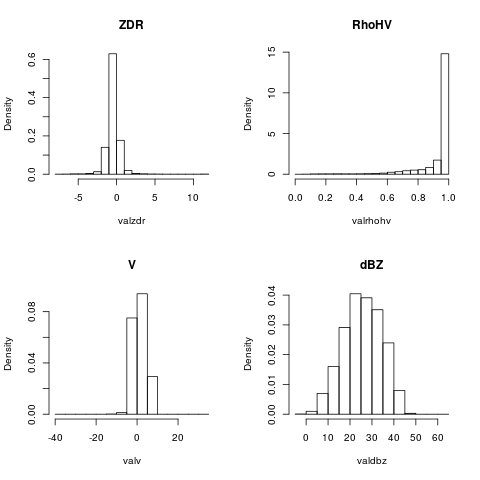

<ListVector - Python:0x7f2baf2a0320 / R:0xda06b58>
[]

In [146]:
############################prueba con R#################################

import rpy2.robjects as robjects
#analizamos la primera elevacion
##miramos solo lo elementos FALSE de las mascaras 
valzdr=zdr[0][~zdr[0].mask].data 
valrhohv=rhohv[0][~rhohv[0].mask].data 
valv=v[0][~v[0].mask].data
valdbz=dbz[0][~dbz[0].mask].data
%R -i valzdr,valrhohv
%R -i valv,valdbz
%R library(ggplot2)
%R par(mfrow= c(2,2)); hist(valzdr,freq=FALSE,main="ZDR")[0]; hist(valrhohv,freq=FALSE,main="RhoHV")[0]; hist(valv, freq=FALSE,main="V")[0]; hist(valdbz, freq=FALSE,main="dBZ")[0]



##histogramas de como se comportan las variables en todos los pixels que escanea el radar


In [9]:
##seleccion de elementos y armado de una nueva mascara
##Futuro: elementos seleccionadps GRC/AP

#supongamos que quiero enmascarar los valores de dbz que sean mayores a 40 //el maximo esta en 62
#Nos quedamos con los que son menores  a 40

#radar.fields['menos_dBZ']
#trabajo=radar.fields['dBZ'].copy()
data=radar.fields['dBZ']['data'].copy()
datos=data.data.copy()
mascara=ma.masked_greater_equal(datos,40)
#mascara=ma.masked_where(datos==-128,datos>=15)
ma.set_fill_value(mascara,-128)
data.mask=mascara.mask
#trabajo['data'].mask=mascara.mask
radar.add_field_like('dBZ','buen_dBZ',data,replace_existing='FALSE')

#radar.fields['menos_dBZ']['data'].mask=mascara.mask


In [10]:
data=radar.fields['dBZ']['data'].copy()
datos=data.data.copy()
mascara=ma.masked_less_equal(datos,40)
ma.set_fill_value(mascara,-128)
data.mask=mascara.mask
#trabajo['data'].mask=mascara.mask
radar.add_field_like('dBZ','dBZ_basura',data,replace_existing='FALSE')



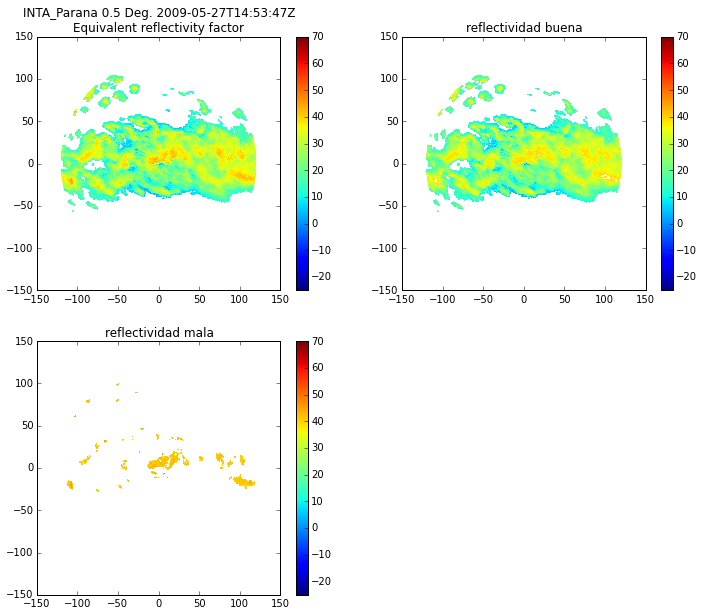

In [12]:
#Graficamos los datos 

xlims=[-150,150]
ylims=[-150,150]

tilt=0

display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=(12, 10))

ax5 = fig.add_subplot(221)
display.plot_ppi('dBZ', tilt, ax=ax5,
                 colorbar_label='',
                 axislabels_flag=False,vmin=-25,vmax=70)
display.set_limits(xlims,ylims)

ax6 = fig.add_subplot(222)
display.plot_ppi('buen_dBZ', tilt, ax=ax6,
                 colorbar_label='',
                 axislabels_flag=False,vmin=-25,vmax=70)
display.set_limits(xlims,ylims)
ax6.set_title(u'reflectividad buena');

ax6 = fig.add_subplot(223)
display.plot_ppi('dBZ_basura', tilt, ax=ax6,
                 colorbar_label='',
                 axislabels_flag=False,vmin=-25,vmax=70)
display.set_limits(xlims,ylims)
ax6.set_title(u'reflectividad mala');

plt.show()



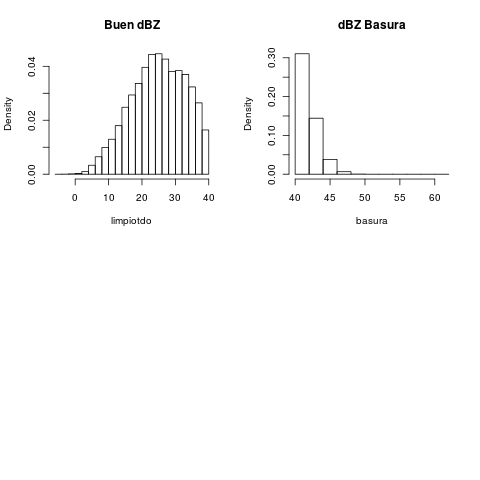

<ListVector - Python:0x7f43bd3f94d0 / R:0x361a5d8>
[]

In [24]:
BdBZ=radar.fields['buen_dBZ']['data']
dbzbueno=[]
for i in range(radar.nsweeps):
    dbzbueno.append(BdBZ[360*i+i:360*(i+1)+i])
    
MdBZ=radar.fields['dBZ_basura']['data']
dbzbasura=[]
for i in range(radar.nsweeps):
    dbzbasura.append(MdBZ[360*i+i:360*(i+1)+i])    

import rpy2.robjects as robjects

limpio=dbzbueno[0][~dbzbueno[0].mask].data ##saco lo elementos de la mascara 
#limpiotdo=limpio.compress(limpio!=-128) ##saco los -128 que vienen con la mascara de una
basura=dbzbasura[0][~dbzbasura[0].mask].data
%R -i limpio,basura
%R par(mfrow= c(2,2));hist(limpiotdo,freq=FALSE,main="Buen dBZ")[0];hist(basura,freq=FALSE,main="dBZ Basura")[0] 
